# Intro<br>
Plot boxplots of features to see their distributions to better understand data and features.<br> <br>
3 main functions:
<ol>
    <li><b>plot_specific_numeric_boxplot(data, feature):</b> plot distribution for numeric features</li>
    <li><b>plot_categorical_frequency_boxplot_simple(data, feature):</b> plot frequency distribution of categorical feature disregarding categories</li>
    <li><b>plot_categorical_frequency_distributions(data, feature):</b> plot frequency distribution for each category</li>
</ol>

# Loading

In [2]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
from importlib import reload

import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC

In [3]:
##### Import results data 
sql_db=Conn_ODBC(database="JE_ML_2025")
conn=sql_db.odbc_conn_db_pyodbc()
sql_query=f"SELECT * FROM [data_p_ishi_GL_JE_cleaned_2019] WHERE AccDocNo LIKE '99%'"
result_df=sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()

result_df.info()
# 1-2 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 77 columns):
FiscalYear                                    156740 non-null int64
AccDocNo                                      156740 non-null int64
Dr_Cr                                         156740 non-null object
DateOfAccDocEntry                             156740 non-null object
DateOfAccDocEntry_and_TimeOfEntry (MYT)       156740 non-null datetime64[ns]
NoOfLineItemInAccDoc                          156740 non-null object
GL_DESCRIPTION                                156740 non-null object
Amt_localCurrencyFormatted                    156740 non-null object
Document Type Description                     156740 non-null object
Quantity                                      156740 non-null object
Username                                      156740 non-null object
TransactionCode                               116843 non-null object
DocHeaderText                                 0 non-nul

# Processing data to get features

In [8]:
amounts = [
'Cr_Asset - Asset',
'Cr_Asset - Customer', 
'Cr_Asset - G\\L Account', 
'Cr_Asset - Material',
'Cr_Cost of Goods Sold (COGS) - G\\L Account',
'Cr_Expense (6) - G\\L Account',
'Cr_Liability - G\\L Account', 
'Cr_Liability - Vendor',
'Cr_Other Costs - G\\L Account', 
'Cr_Other Revenue - G\\L Account', 
'Cr_Revenue - G\\L Account', 
'Dr_Asset - Asset', 
'Dr_Asset - Customer', 
'Dr_Asset - G\\L Account', 
'Dr_Asset - Material', 
'Dr_Cost of Goods Sold (COGS) - G\\L Account', 
'Dr_Expense (6) - G\\L Account', 
'Dr_Liability - G\\L Account', 
'Dr_Liability - Vendor', 
'Dr_Other Costs - G\\L Account', 
'Dr_Other Revenue - G\\L Account', 
'Dr_Revenue - G\\L Account'
]

In [9]:
features = [
'GL_DESCRIPTION',
'Amt_localCurrencyFormatted',
'Document Type Description',
'Quantity',
'Username',
'TransactionCode',
'DocHeaderText',
'IsDocReversalOrReversedDoc',
'IdOfLineItem',
'PostingKey',
'isLineItemAutomaticallyCreated',
'TermsOfPayment',
'CashDiscountAmountInLocalCurrency',
'PaymentMethod',
'Plant',
'hasSubsequentDrCrMemo',
'WBSElement',
'SpecialGLIndicator',

'GL_AccType_AccountTypeDesc',
'Username Type',
'Amt_DocCurrency_NoOfTrailingZeroes',
'CashDiscountPercentage',
'IND_MonthEnd',
'IND_QuarterEnd',
'IND_YearEnd',
'IND_Weekend',
'IND_PublicHol',
'IND_OutsideWorkHours',

# New features from ZOTC
# 'Carrier Key Desc'
]

In [10]:
encoded_cols = [col for col in result_df.columns if col.startswith('labelled_')]
print(len(encoded_cols))

encoded_cols.remove('labelled_GL_AccType')
encoded_cols.remove('labelled_AccountTypeDesc')
print(len(encoded_cols))
encoded_cols

15
13


['labelled_GL_AccType_AccountTypeDesc',
 'labelled_Document Type Description',
 'labelled_TransactionCode',
 'labelled_IdOfLineItem',
 'labelled_PostingKey',
 'labelled_isLineItemAutomaticallyCreated',
 'labelled_TermsOfPayment',
 'labelled_PaymentMethod',
 'labelled_FollowOnDocType',
 'labelled_Plant',
 'labelled_hasSubsequentDrCrMemo',
 'labelled_SpecialGLIndicator',
 'labelled_Username Type']

In [11]:
# List to store matches
revenue_list = []

# String to search for
search_term = "revenue"

# Case-insensitive search and add matches to new list
for s in amounts:
    if search_term.lower() in s.lower():
        revenue_list.append(s)

revenue_list

['Cr_Other Revenue - G\\L Account',
 'Cr_Revenue - G\\L Account',
 'Dr_Other Revenue - G\\L Account',
 'Dr_Revenue - G\\L Account']

In [12]:
def calculate_revenue(row, revenue_list):
    total = 0
    for col in revenue_list:
        if col.startswith('Cr_'):
            total -= row[col]
        elif col.startswith('Dr_'):
            total -= row[col]
    return total

# Apply function row-wise
result_df['Revenue'] = result_df.apply(calculate_revenue, axis=1, revenue_list=revenue_list)

In [13]:
# result_df.iloc[11]

In [14]:
# Columns to sum up
sum_cols = ['Amt_DocCurrency_NoOfTrailingZeroes', 'Quantity']

for col in sum_cols:
    result_df[f'sum_{col}'] = result_df[col].apply(sum)

In [15]:
# Count distinct values for columns
def count_distinct_values(lst):
    return len(set(lst))

columns_to_d = ['IdOfLineItem', 'PostingKey', 'TermsOfPayment']

for col in columns_to_d:
    result_df[f'distinct_{col}'] = result_df[col].apply(count_distinct_values)

In [16]:
from collections import Counter
def expand_list_frequencies_multi_with_missing(df, col_names, missing_label='MISSING'):
    """
    Expands multiple list columns into frequency columns for each unique item,
    including counts of None/NaN values as a separate category.

    Parameters:
        df (pd.DataFrame): The input DataFrame
        col_names (list of str): List of column names containing lists
        missing_label (str): Label used to represent missing values in output columns
    
    Returns:
        pd.DataFrame: A new DataFrame with frequency columns added
    """
    result_df = df.copy()

    for col in col_names:
        def counter_with_missing(lst):
            counts = Counter()
            for item in lst:
                if pd.isna(item):  # catches None, np.nan, pd.NA
                    counts[missing_label] += 1
                else:
                    counts[item] += 1
            return dict(counts)

        # Apply counter and convert to DataFrame
        freq_df = result_df[col].apply(counter_with_missing).apply(pd.Series)

        # Fill NaNs with 0
        freq_df = freq_df.fillna(0).astype(int)

        # Add prefix to avoid conflicts across columns
        freq_df = freq_df.add_prefix(f"{col}_")

        # Join back to main DataFrame
        result_df = pd.concat([result_df.reset_index(drop=True), freq_df.reset_index(drop=True)], axis=1)

    return result_df

In [17]:
# Expand the columns based on how many distinct values are available and how often they appear for each JE
cols_to_dc = ['SpecialGLIndicator', 'Plant', 'hasSubsequentDrCrMemo', 'isLineItemAutomaticallyCreated', 'PaymentMethod']

df_result = expand_list_frequencies_multi_with_missing(result_df, col_names=cols_to_dc)
df_result.info()
# 5 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 97 columns):
FiscalYear                                    156740 non-null int64
AccDocNo                                      156740 non-null int64
Dr_Cr                                         156740 non-null object
DateOfAccDocEntry                             156740 non-null object
DateOfAccDocEntry_and_TimeOfEntry (MYT)       156740 non-null datetime64[ns]
NoOfLineItemInAccDoc                          156740 non-null object
GL_DESCRIPTION                                156740 non-null object
Amt_localCurrencyFormatted                    156740 non-null object
Document Type Description                     156740 non-null object
Quantity                                      156740 non-null object
Username                                      156740 non-null object
TransactionCode                               116843 non-null object
DocHeaderText                                 0 non-nul

In [18]:
non_features = ['Dr_Cr','FiscalYear', 'AccDocNo', 'DateOfAccDocEntry', 'DateOfAccDocEntry_and_TimeOfEntry (MYT)', 'NoOfLineItemInAccDoc','Customer PO Number', 
'IS Rep', 'Sold-To Id', 'Cluster_ID', 'Carrier Key Desc']

# Get boolean cols

bool_cols = df_result.select_dtypes(include='bool').columns
if bool_cols.empty:
    print('No bool cols')
else:
    print(bool_cols)

    # Convert bool cols to int
    df_result[bool_cols] = df_result[bool_cols].astype(int)

# Get numerical feature columns
def get_num_cols(df):
    numerical_cols = df.select_dtypes(include='number').columns.tolist()

    numerical_cols = [item for item in numerical_cols if item not in non_features]

    return numerical_cols

num_cols = get_num_cols(df_result)
print(len(num_cols))
print(num_cols)

No bool cols
52
['IsDocReversalOrReversedDoc', 'IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd', 'IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours', 'labelled_Document Type Description', 'labelled_TransactionCode', 'labelled_Username Type', 'Cr_Asset - Asset', 'Cr_Asset - Customer', 'Cr_Asset - G\\L Account', 'Cr_Asset - Material', 'Cr_Cost of Goods Sold (COGS) - G\\L Account', 'Cr_Expense (6) - G\\L Account', 'Cr_Liability - G\\L Account', 'Cr_Liability - Vendor', 'Cr_Other Costs - G\\L Account', 'Cr_Other Revenue - G\\L Account', 'Cr_Revenue - G\\L Account', 'Dr_Asset - Asset', 'Dr_Asset - Customer', 'Dr_Asset - G\\L Account', 'Dr_Asset - Material', 'Dr_Cost of Goods Sold (COGS) - G\\L Account', 'Dr_Expense (6) - G\\L Account', 'Dr_Liability - G\\L Account', 'Dr_Liability - Vendor', 'Dr_Other Costs - G\\L Account', 'Dr_Other Revenue - G\\L Account', 'Dr_Revenue - G\\L Account', 'Revenue', 'sum_Amt_DocCurrency_NoOfTrailingZeroes', 'sum_Quantity', 'distinct_IdOfLineItem', 'distinct_

In [19]:
# Select relevant features for anomaly detection
df_numeric = df_result[num_cols].copy()
df_numeric.columns.tolist()

# Preprocess the data (important for density-based methods)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_features)

['IsDocReversalOrReversedDoc',
 'IND_MonthEnd',
 'IND_QuarterEnd',
 'IND_YearEnd',
 'IND_Weekend',
 'IND_PublicHol',
 'IND_OutsideWorkHours',
 'labelled_Document Type Description',
 'labelled_TransactionCode',
 'labelled_Username Type',
 'Cr_Asset - Asset',
 'Cr_Asset - Customer',
 'Cr_Asset - G\\L Account',
 'Cr_Asset - Material',
 'Cr_Cost of Goods Sold (COGS) - G\\L Account',
 'Cr_Expense (6) - G\\L Account',
 'Cr_Liability - G\\L Account',
 'Cr_Liability - Vendor',
 'Cr_Other Costs - G\\L Account',
 'Cr_Other Revenue - G\\L Account',
 'Cr_Revenue - G\\L Account',
 'Dr_Asset - Asset',
 'Dr_Asset - Customer',
 'Dr_Asset - G\\L Account',
 'Dr_Asset - Material',
 'Dr_Cost of Goods Sold (COGS) - G\\L Account',
 'Dr_Expense (6) - G\\L Account',
 'Dr_Liability - G\\L Account',
 'Dr_Liability - Vendor',
 'Dr_Other Costs - G\\L Account',
 'Dr_Other Revenue - G\\L Account',
 'Dr_Revenue - G\\L Account',
 'Revenue',
 'sum_Amt_DocCurrency_NoOfTrailingZeroes',
 'sum_Quantity',
 'distinct_IdOfLi

# Functions

In [4]:
def plot_specific_numeric_boxplot(df, column_name, figsize=(8, 6)):
    """
    Plot a boxplot for a specific numeric column.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    column_name (str): Name of the numeric column to plot
    figsize (tuple): Figure size (width, height)
    
    Returns:
    None: Displays the plot
    """
    # Check if column exists
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame!")
        return
    
    # Check if column is numeric
    if not np.issubdtype(df[column_name].dtype, np.number):
        print(f"Column '{column_name}' is not numeric!")
        return
    
    # Drop NaNs for accurate stats
    col_data = df[column_name].dropna()

    # Calculate statistics
    mean_val = col_data.mean()
    median_val = col_data.median()
    q1 = col_data.quantile(0.25)
    q3 = col_data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    print(lower_bound)
    upper_bound = q3 + (1.5 * iqr)
    print(upper_bound)
    outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]

    # Create figure
    plt.figure(figsize=figsize)
    
    # Create boxplot
    df.boxplot(column=column_name,vert=True)
    plt.title(f'Boxplot of {column_name}')
    plt.ylabel(column_name)
    plt.xlabel('')
    
    # Annotate stats
    plt.axhline(mean_val, color='orange', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axhline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    plt.axhline(q1, color='blue', linestyle=':', label=f'Q1: {q1:.2f}')
    plt.axhline(q3, color='blue', linestyle=':', label=f'Q3: {q3:.2f}')
    plt.axhline(lower_bound, color='red', linestyle='--', label=f'Lower bound (1.5*IQR): {lower_bound}')
    plt.axhline(upper_bound, color='red', linestyle='--', label=f'Upper bound (1.5*IQR): {upper_bound}')

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    if not outliers.empty:
        print(f"🔍 Found {len(outliers)} outliers:")
        # print(outliers.values)
        
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_categorical_frequency_boxplot_simple(df, column_name, title=None, figsize=(10, 6)):
    """
    Show boxplot distribution of frequencies disregarding the different categories in a categorical feature 
    Use for categorical features which have 1 category / similar categories

    Simplified version that's more robust for handling array comparisons. 
    Includes NULL values as 'MISSING' category and displays list of detected categories.
    """
    
    # Extract all values from the specified column
    all_values = []
    
    for idx, row in df.iterrows():
        value = row[column_name]
        
        # Handle missing values: None, NaN, empty list/array
        if value is None or (isinstance(value, (float, np.floating)) and np.isnan(value)):
            all_values.append("MISSING")
        elif isinstance(value, (list, np.ndarray, pd.Series)):
            if len(value) == 0:
                all_values.append("MISSING")
            else:
                # Process each element in the collection
                for v in value:
                    # Handle nested numpy arrays/scalars
                    if isinstance(v, np.ndarray) and v.size == 1:
                        v = v.item()
                    if v is None or (isinstance(v, (float, np.floating)) and np.isnan(v)):
                        all_values.append("MISSING")
                    else:
                        all_values.append(str(v))  # Convert to string to avoid type issues
        else:
            # Single valid value
            all_values.append(str(value))
    
    # Count frequency of each category
    if len(all_values) > 0:
        value_counts = pd.Series(all_values).value_counts()
    else:
        value_counts = pd.Series(dtype=int)
    
    # Get frequencies for boxplot
    frequencies = value_counts.values if len(value_counts) > 0 else np.array([])
    
    # Get unique categories
    unique_categories = list(value_counts.index) if len(value_counts) > 0 else []
    
    # Handle case where no valid data exists
    if len(frequencies) == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, 'No valid data found', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title or f'Frequency Distribution of {column_name}')
        return fig
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create boxplot
    ax.boxplot(frequencies, 
               labels=['All Categories'], 
               patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    # Customize the plot
    ax.set_ylabel('Frequency Count')
    ax.set_title(title or f'Frequency Distribution of {column_name}')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = (f'Total Categories: {len(frequencies)}\n'
                  f'Mean Freq: {np.mean(frequencies):.1f}\n'
                  f'Median Freq: {np.median(frequencies):.1f}')
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add categories list
    if unique_categories:
        # Format categories list for better display
        categories_text = "Categories:\n" + "\n".join([f"• {cat}" for cat in unique_categories[:10]])  # Show first 10
        if len(unique_categories) > 10:
            categories_text += f"\n... and {len(unique_categories) - 10} more"
        
        ax.text(0.98, 0.98, categories_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                fontsize=8)
    
    plt.tight_layout()
    
    return fig

In [ ]:
def plot_category_frequency_distributions(df, column_name, title=None, figsize=(12, 8), max_categories=20):
    """
    Creates boxplots showing frequency distributions for each distinct category within a categorical feature.
    
    Parameters:
    df: DataFrame containing the data
    column_name: Name of the column containing lists of categories
    title: Optional title for the overall plot
    figsize: Figure size tuple
    max_categories: Maximum number of categories to display (to avoid overcrowded plots)
    """
    
    # Dictionary to store frequencies for each category
    category_frequencies = {}
    
    # Go through each row in the dataframe
    for idx, row in df.iterrows():
        value = row[column_name]
        
        # Initialize a temporary counter for this row
        row_category_counts = {}
        
        # Handle different data types
        if value is None or (isinstance(value, (float, np.floating)) and np.isnan(value)):
            # Count NULL as "MISSING"
            row_category_counts["MISSING"] = row_category_counts.get("MISSING", 0) + 1
        elif isinstance(value, (list, np.ndarray, pd.Series)):
            if len(value) == 0:
                row_category_counts["MISSING"] = row_category_counts.get("MISSING", 0) + 1
            else:
                # Process each element in the collection
                for v in value:
                    # Handle nested numpy arrays/scalars
                    if isinstance(v, np.ndarray) and v.size == 1:
                        v = v.item()
                    if v is None or (isinstance(v, (float, np.floating)) and np.isnan(v)):
                        category_key = "MISSING"
                    else:
                        category_key = str(v)
                    
                    row_category_counts[category_key] = row_category_counts.get(category_key, 0) + 1
        else:
            # Single valid value
            category_key = str(value) if not (isinstance(value, (float, np.floating)) and np.isnan(value)) else "MISSING"
            row_category_counts[category_key] = row_category_counts.get(category_key, 0) + 1
        
        # Add counts to overall category frequencies
        for category, count in row_category_counts.items():
            if category not in category_frequencies:
                category_frequencies[category] = []
            category_frequencies[category].append(count)
    
    # Handle case where no valid data exists
    if len(category_frequencies) == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, 'No valid data found', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title or f'Category Frequency Distributions for {column_name}')
        return fig
    
    # Sort categories for consistent ordering
    sorted_categories = sorted(category_frequencies.keys())
    
    # Limit categories if there are too many
    if len(sorted_categories) > max_categories:
        categories_to_plot = sorted_categories[:max_categories]
        remaining_count = len(sorted_categories) - max_categories
    else:
        categories_to_plot = sorted_categories
        remaining_count = 0
    
    # Create the plot
    n_categories = len(categories_to_plot)
    if n_categories == 1:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
    else:
        # Determine subplot layout
        n_cols = min(4, n_categories)  # Max 4 columns
        n_rows = (n_categories + n_cols - 1) // n_cols
        
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(n_rows, n_cols, figure=fig)
        axes = []
        
        for i in range(n_categories):
            row = i // n_cols
            col = i % n_cols
            axes.append(fig.add_subplot(gs[row, col]))
    
    # Create boxplot for each category
    for i, category in enumerate(categories_to_plot):
        ax = axes[i] if n_categories > 1 else axes[0]
        frequencies = category_frequencies[category]
        
        # Create boxplot
        box_plot = ax.boxplot(frequencies, 
                             labels=[category], 
                             patch_artist=True,
                             boxprops=dict(facecolor='lightblue', alpha=0.7),
                             medianprops=dict(color='red', linewidth=2))
        
        # Customize the plot
        ax.set_ylabel('Frequency per Row')
        ax.set_title(f'Category: {category}')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        # Count = Number of JEs with instance of category
        mean_freq = np.mean(frequencies)
        median_freq = np.median(frequencies)
        frequencies_array = np.array(frequencies)
        min_val = np.min(frequencies_array)
        max_val = np.max(frequencies_array)
        q1 = np.percentile(frequencies_array, 25)
        q3 = np.percentile(frequencies_array, 75)
        
        stats_text = (f'Count: {len(frequencies)}\n'
                     f'Min: {min_val}\n'
                     f'Q1: {q1:.1f}\n'
                     f'Median: {median_freq:.1f}\n'
                     f'Q3: {q3:.1f}\n'
                     f'Max: {max_val:.0f}\n'
                     f'Mean: {mean_freq:.2f}')
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=8)
    
    # Handle remaining categories message
    if remaining_count > 0:
        if n_categories > 1:
            # Add a text box indicating how many categories were not plotted
            fig.text(0.5, 0.02, f'Note: {remaining_count} additional categories not shown', 
                    ha='center', va='bottom', style='italic')
        else:
            axes[0].text(0.5, 0.02, f'Note: {remaining_count} additional categories not shown', 
                        transform=axes[0].transAxes, ha='center', va='bottom', style='italic')
    
    # Set overall title
    if n_categories > 1:
        fig.suptitle(title or f'Category Frequency Distributions for {column_name}', fontsize=14, y=0.98)
    else:
        axes[0].set_title(title or f'Category Frequency Distributions for {column_name}', fontsize=14)
    
    plt.tight_layout()
    
    # Adjust layout to accommodate suptitle
    if n_categories > 1:
        plt.subplots_adjust(top=0.93)
    
    return fig

# Results<br>
'IsDocReversalOrReversedDoc',
 'IND_MonthEnd',
 'IND_QuarterEnd',
 'IND_YearEnd',
 'IND_Weekend',
 'IND_PublicHol',
 'IND_OutsideWorkHours',
 'labelled_Document Type Description',
 'labelled_TransactionCode',
 'labelled_Username Type', Amounts
 'Revenue',
 'sum_Amt_DocCurrency_NoOfTrailingZeroes',
 'sum_Quantity',
 'distinct_IdOfLineItem',
 'distinct_PostingKey',
 'distinct_TermsOfPayment',
 'SpecialGLIndicator',
 'Plant',
 'hasSubsequentDrCrMemo',
 'isLineItemAutomaticallyCreated',
 'PaymentMethod'

## Numeric features<br>
Amounts, Revenue, sum_Amt_DocCurrency_NoOfTrailingZeroes, sum_Quantity

### Revenue

-5917.5
10878.5
🔍 Found 18843 outliers:


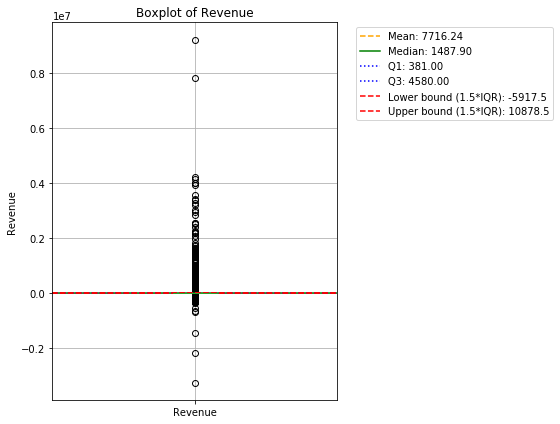

In [20]:
plot_specific_numeric_boxplot(df_numeric, 'Revenue')

### Trailing 0s

-3.0
5.0
🔍 Found 7900 outliers:


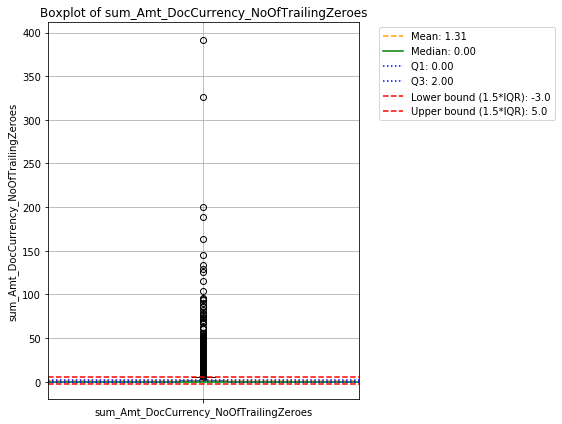

In [21]:
plot_specific_numeric_boxplot(df_numeric, 'sum_Amt_DocCurrency_NoOfTrailingZeroes')

### sum_Quantity (not good feature)

-14.0
26.0
🔍 Found 20531 outliers:


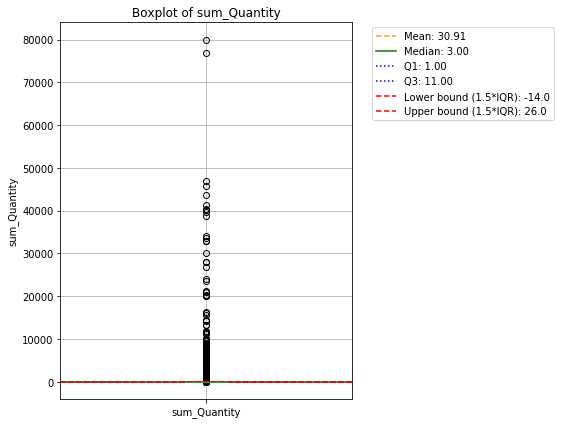

In [22]:
plot_specific_numeric_boxplot(df_numeric, 'sum_Quantity')

### Amounts

Cr_Asset - Asset skipped due to having only one distinct val
0.0
0.0
🔍 Found 9685 outliers:


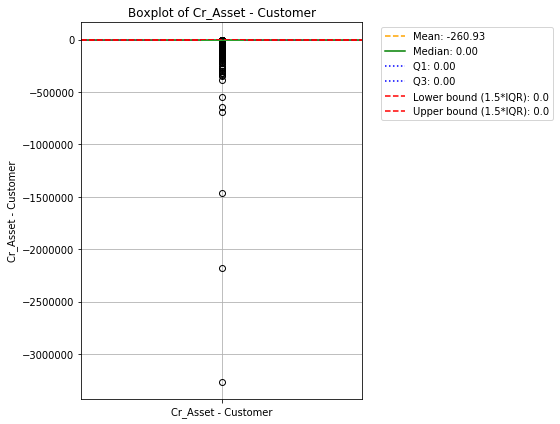

0.0
0.0
🔍 Found 24959 outliers:


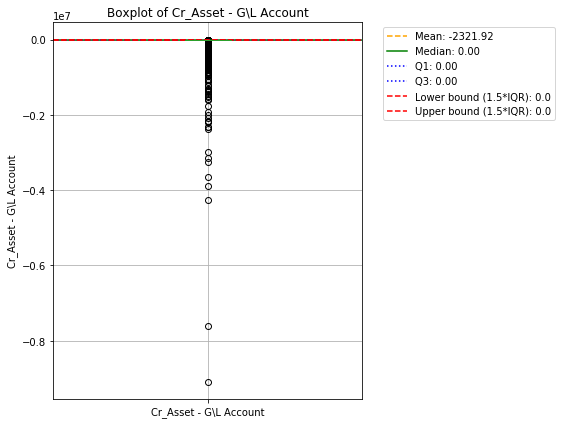

Cr_Asset - Material skipped due to having only one distinct val
0.0
0.0
🔍 Found 20932 outliers:


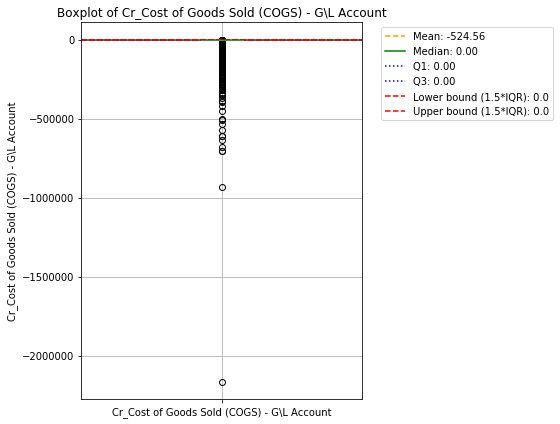

Cr_Expense (6) - G\L Account skipped due to having only one distinct val
0.0
0.0
🔍 Found 1868 outliers:


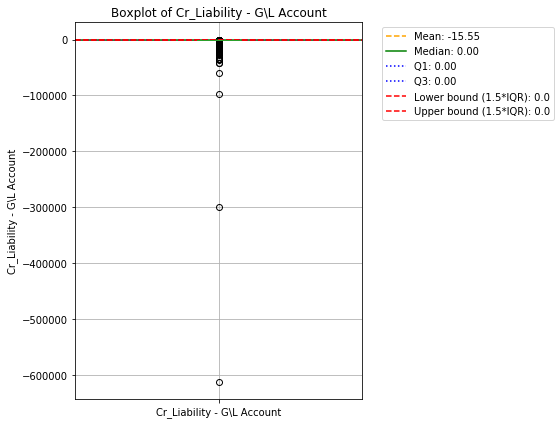

Cr_Liability - Vendor skipped due to having only one distinct val
0.0
0.0
🔍 Found 161 outliers:


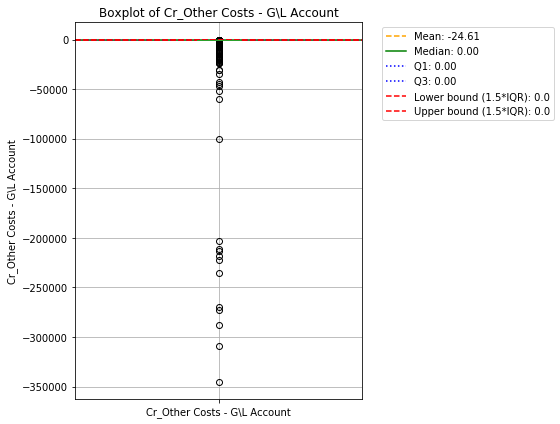

0.0
0.0
🔍 Found 5526 outliers:


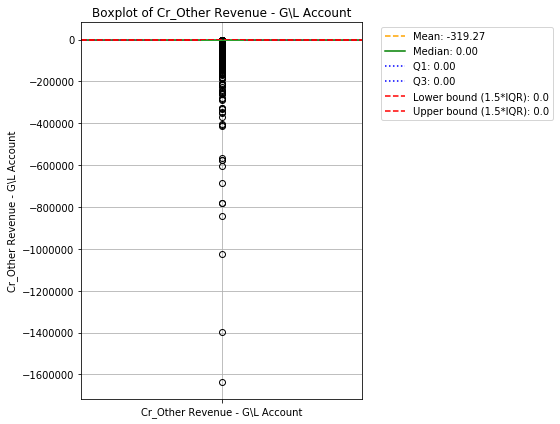

-10623.067500000001
5844.9125
🔍 Found 18364 outliers:


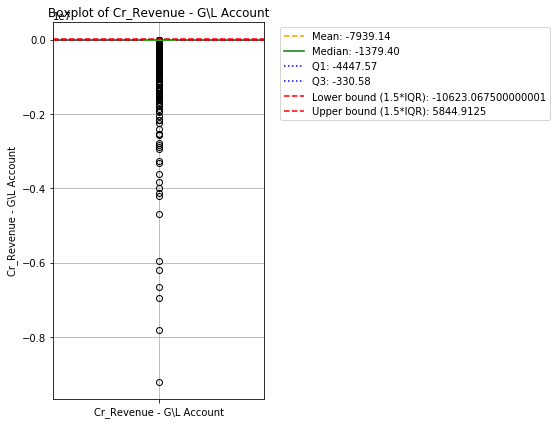

Dr_Asset - Asset skipped due to having only one distinct val
-5929.5
10898.5
🔍 Found 18320 outliers:


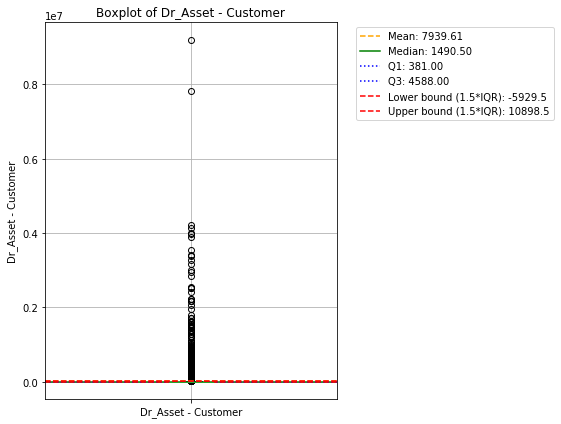

0.0
0.0
🔍 Found 113 outliers:


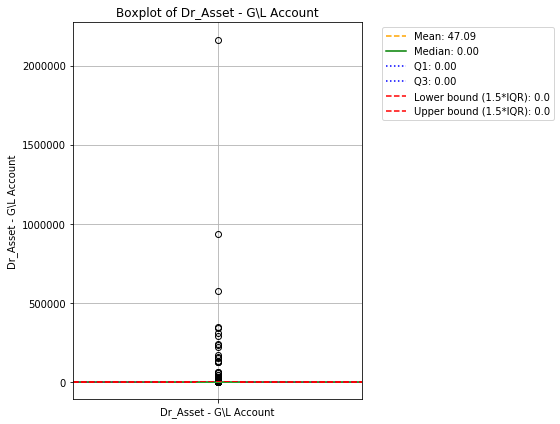

Dr_Asset - Material skipped due to having only one distinct val
0.0
0.0
🔍 Found 22098 outliers:


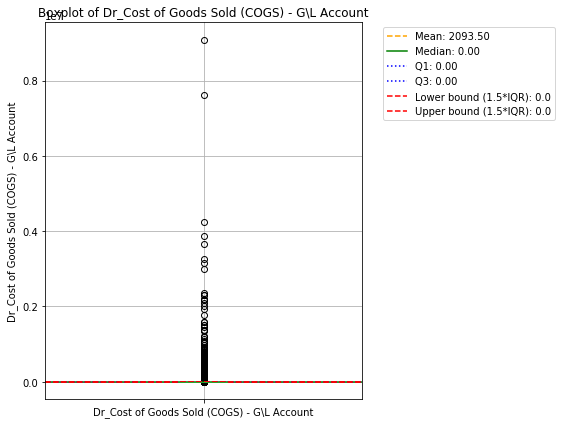

Dr_Expense (6) - G\L Account skipped due to having only one distinct val
0.0
0.0
🔍 Found 24098 outliers:


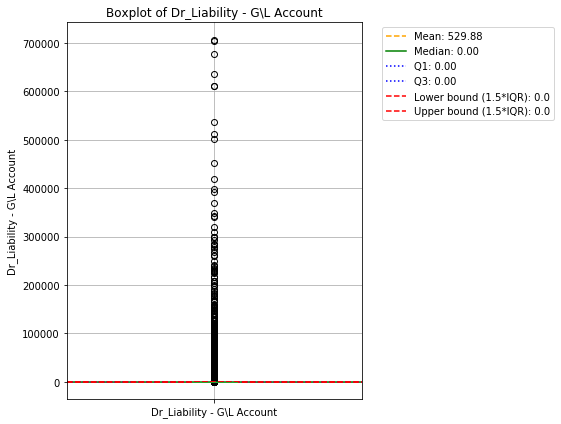

Dr_Liability - Vendor skipped due to having only one distinct val
0.0
0.0
🔍 Found 5011 outliers:


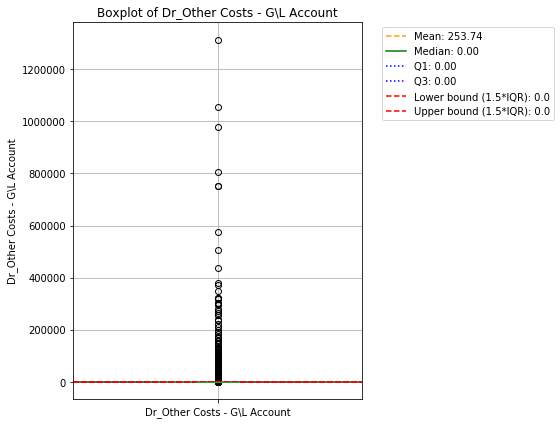

0.0
0.0
🔍 Found 482 outliers:


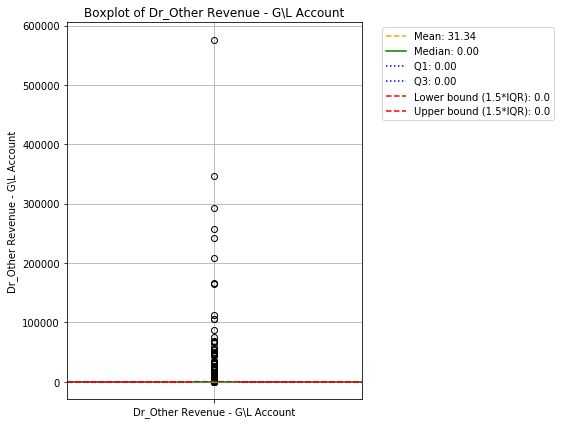

0.0
0.0
🔍 Found 15267 outliers:


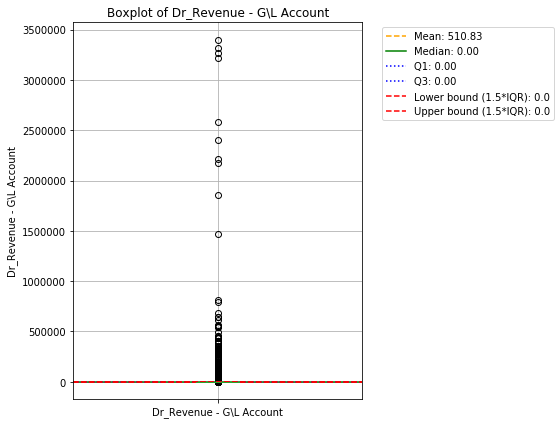

In [23]:
for col in amounts:
    if len(df_numeric[col].value_counts().keys()) != 1:
        plot_specific_numeric_boxplot(df_numeric, col)
    else:
        print(f'{col} skipped due to having only one distinct val')

0.0
0.0


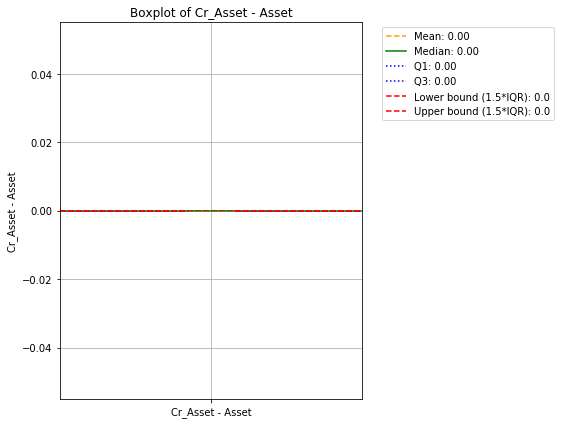

0.0
0.0
🔍 Found 9685 outliers:


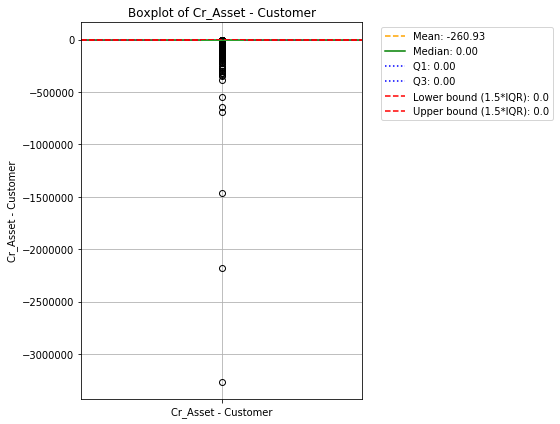

0.0
0.0
🔍 Found 24959 outliers:


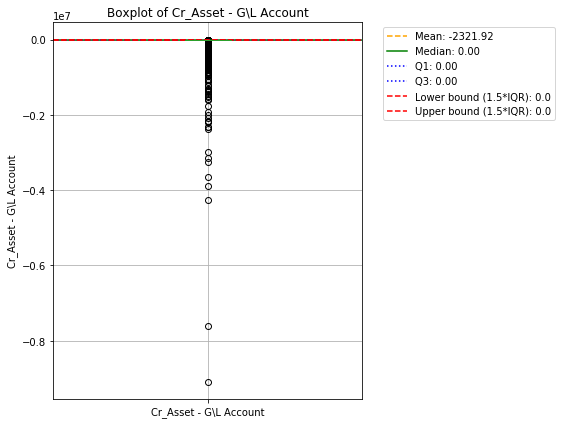

0.0
0.0


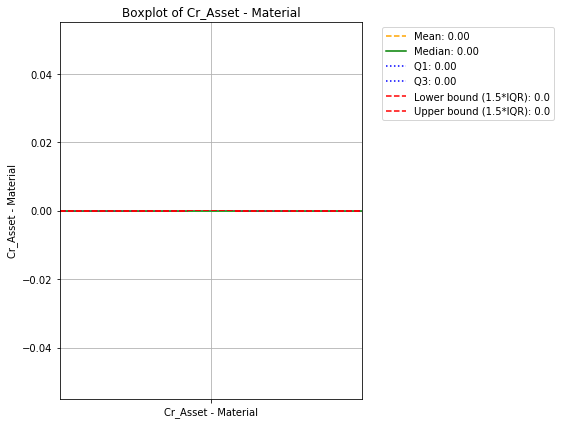

0.0
0.0
🔍 Found 20932 outliers:


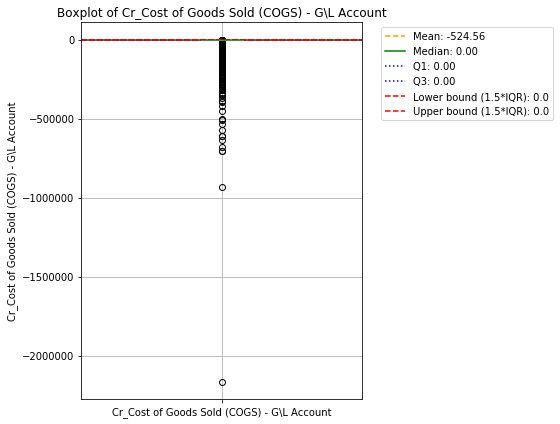

0.0
0.0


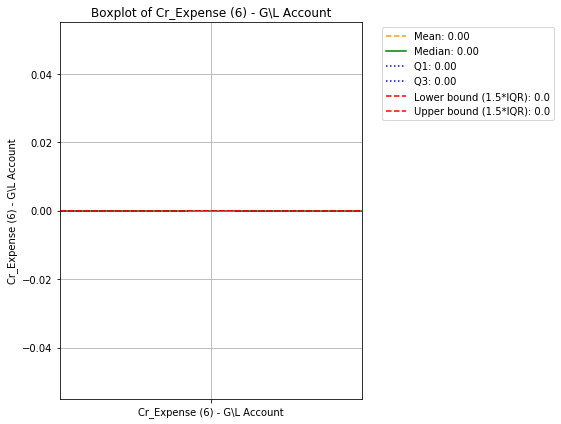

0.0
0.0
🔍 Found 1868 outliers:


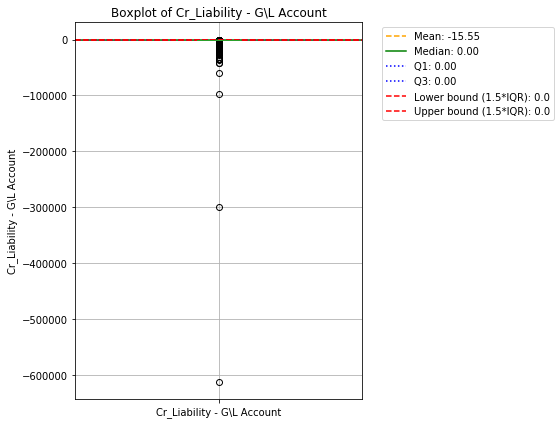

0.0
0.0


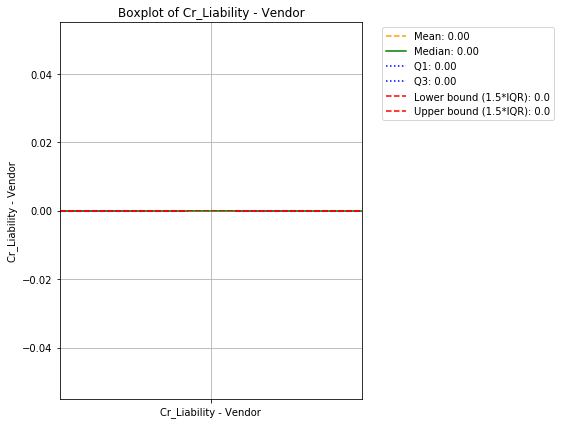

0.0
0.0
🔍 Found 161 outliers:


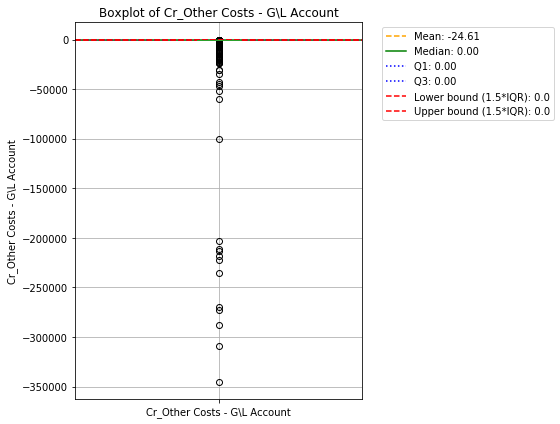

0.0
0.0
🔍 Found 5526 outliers:


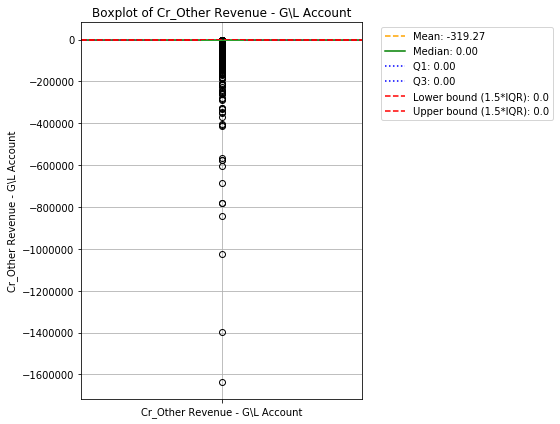

-10623.067500000001
5844.9125
🔍 Found 18364 outliers:


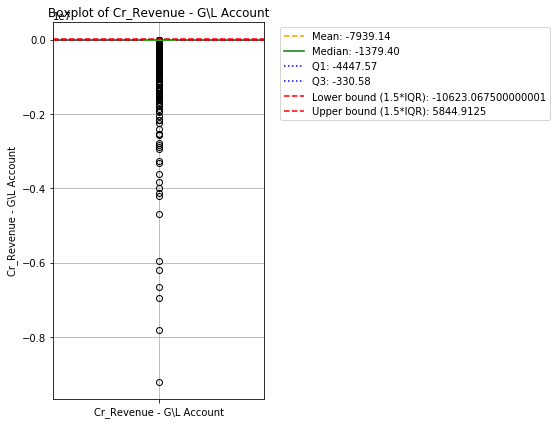

0.0
0.0


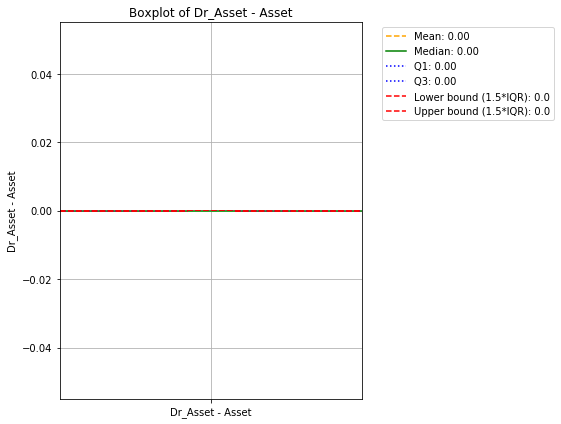

-5929.5
10898.5
🔍 Found 18320 outliers:


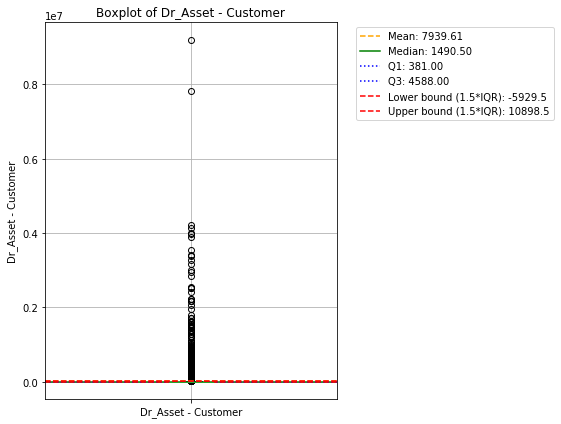

0.0
0.0
🔍 Found 113 outliers:


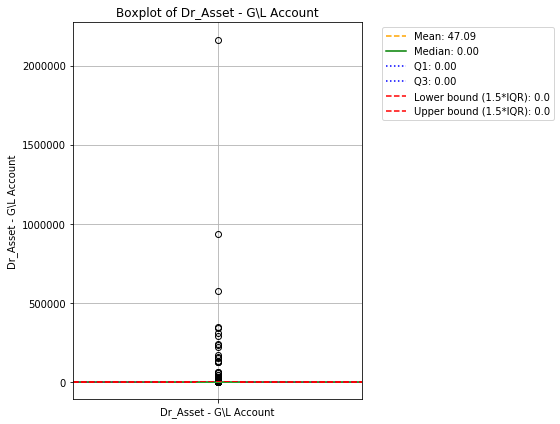

0.0
0.0


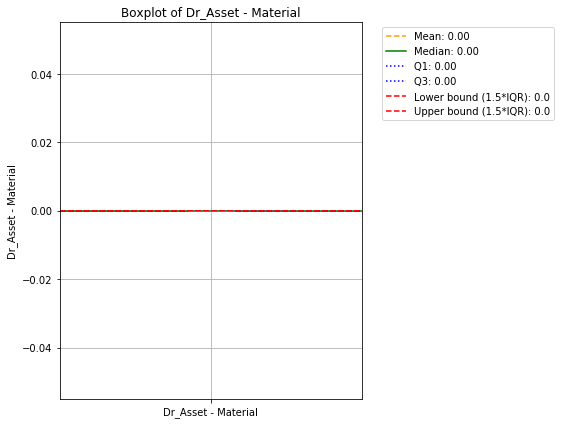

0.0
0.0
🔍 Found 22098 outliers:


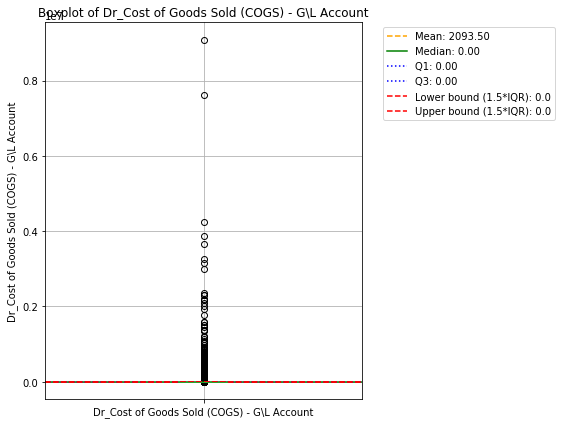

0.0
0.0


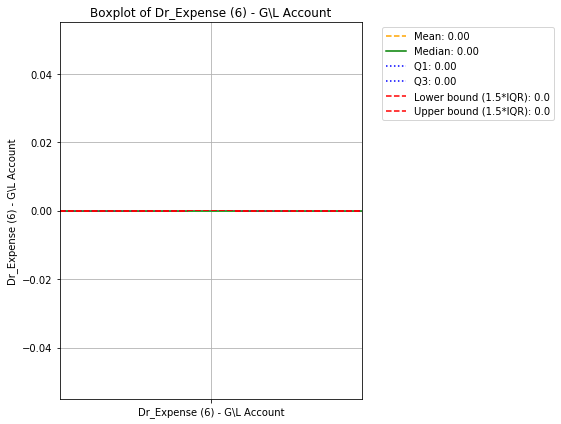

0.0
0.0
🔍 Found 24098 outliers:


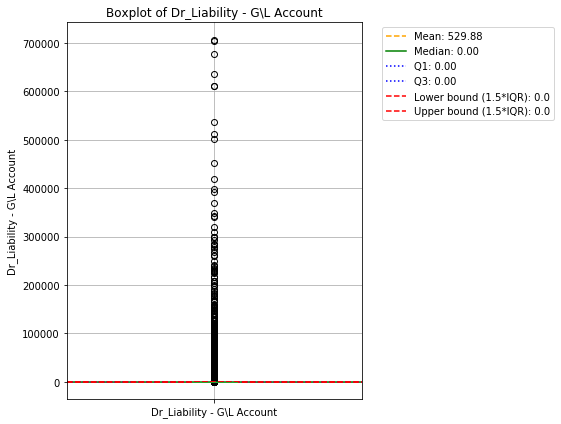

0.0
0.0


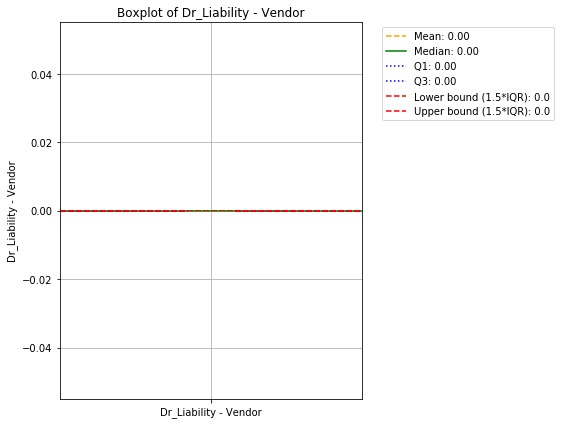

0.0
0.0
🔍 Found 5011 outliers:


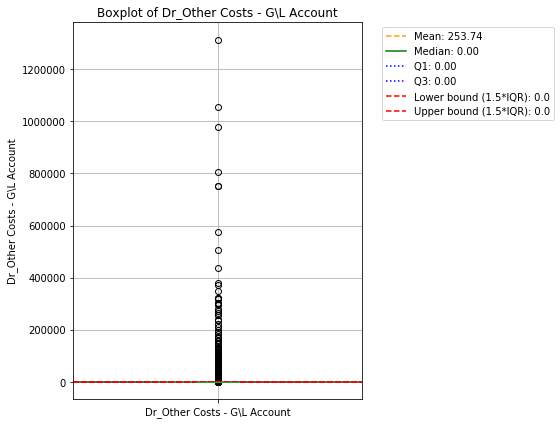

0.0
0.0
🔍 Found 482 outliers:


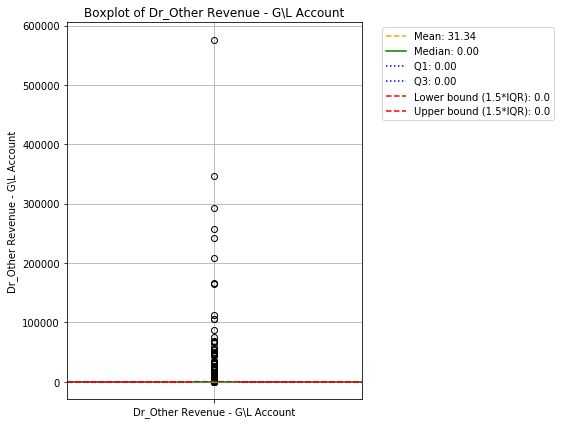

0.0
0.0
🔍 Found 15267 outliers:


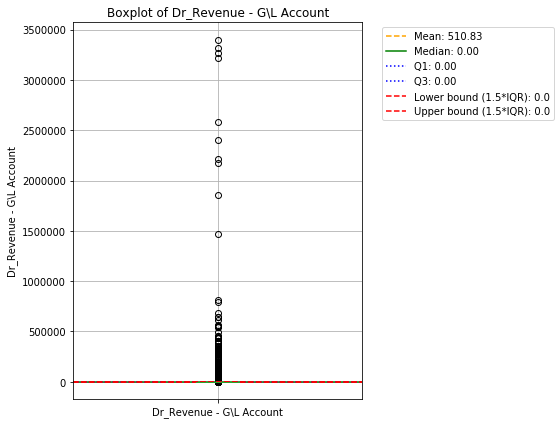

In [24]:
# For numeric features
for col in amounts:
    plot_specific_numeric_boxplot(df_numeric, col)

## Categorical features

In [25]:
cols_to_dc = ['SpecialGLIndicator', 'Plant', 'hasSubsequentDrCrMemo', 'isLineItemAutomaticallyCreated', 'PaymentMethod']
matches = [col for col in df_numeric.columns.tolist() if any(sub in col for sub in cols_to_dc)]
print(matches)

['SpecialGLIndicator_MISSING', 'Plant_MISSING', 'Plant_MY01', 'Plant_MY04', 'Plant_MY03', 'Plant_MY05', 'Plant_MY02', 'hasSubsequentDrCrMemo_MISSING', 'isLineItemAutomaticallyCreated_MISSING', 'isLineItemAutomaticallyCreated_X', 'PaymentMethod_MISSING', 'PaymentMethod_2', 'PaymentMethod_1', 'PaymentMethod_L']


### IsDocReversalOrReversedDoc (JE level)

In [58]:
df_result['IsDocReversalOrReversedDoc'].value_counts(dropna=False)

NaN     155972
 2.0       386
 1.0       382
Name: IsDocReversalOrReversedDoc, dtype: int64

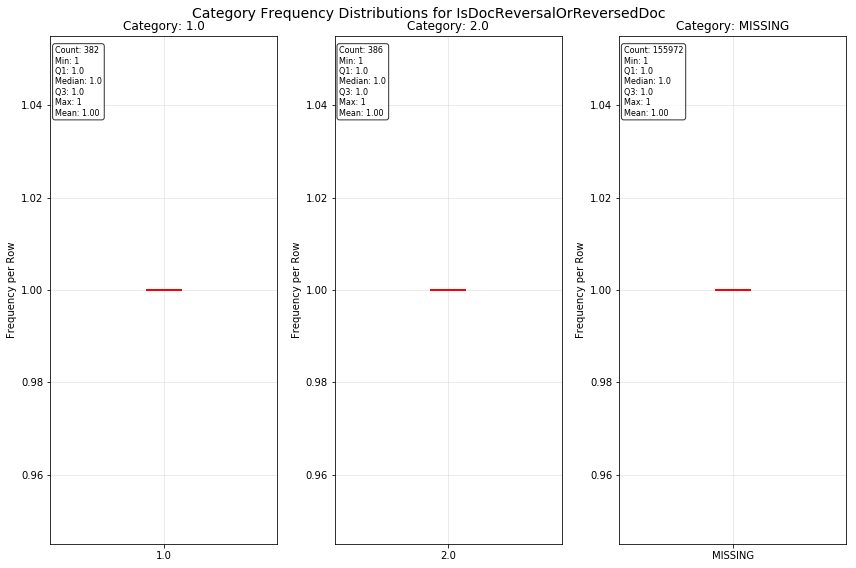

In [26]:
fig = plot_category_frequency_distributions(df_result, 'IsDocReversalOrReversedDoc')
plt.show()

### IdOfLineItem

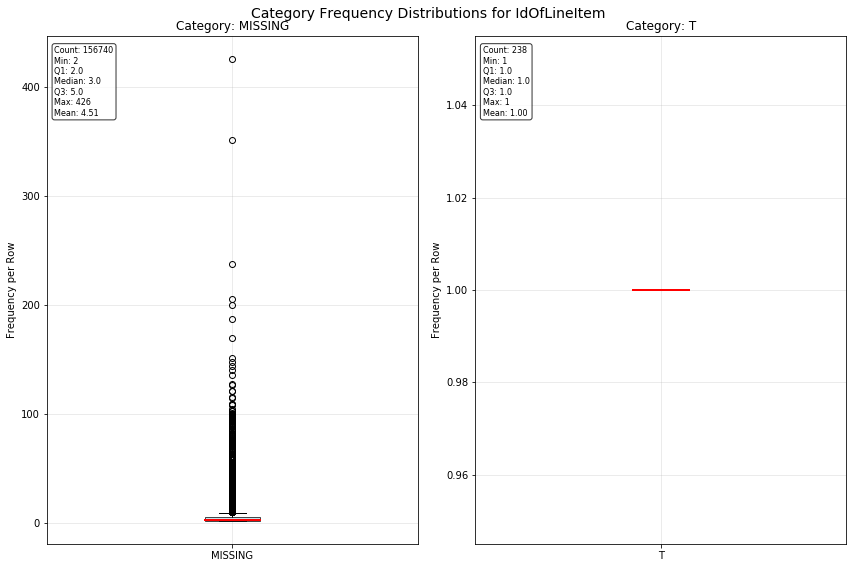

In [27]:
fig = plot_category_frequency_distributions(df_result, 'IdOfLineItem')
plt.show()

In [28]:
df_numeric['distinct_IdOfLineItem'].value_counts()

1    156502
2       238
Name: distinct_IdOfLineItem, dtype: int64

1.0
1.0
🔍 Found 238 outliers:


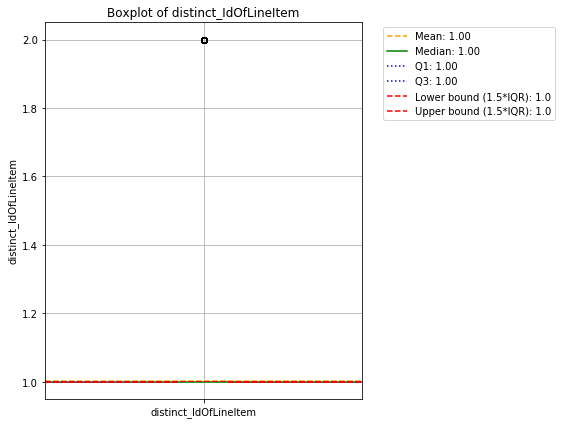

In [29]:
plot_specific_numeric_boxplot(df_numeric, 'distinct_IdOfLineItem')

### PostingKey

0.5
4.5


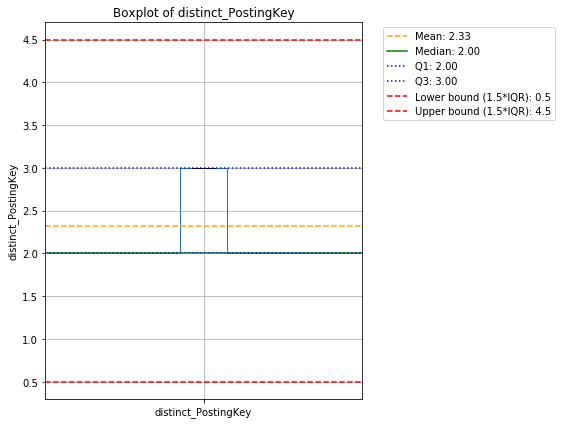

In [30]:
plot_specific_numeric_boxplot(df_numeric, 'distinct_PostingKey')

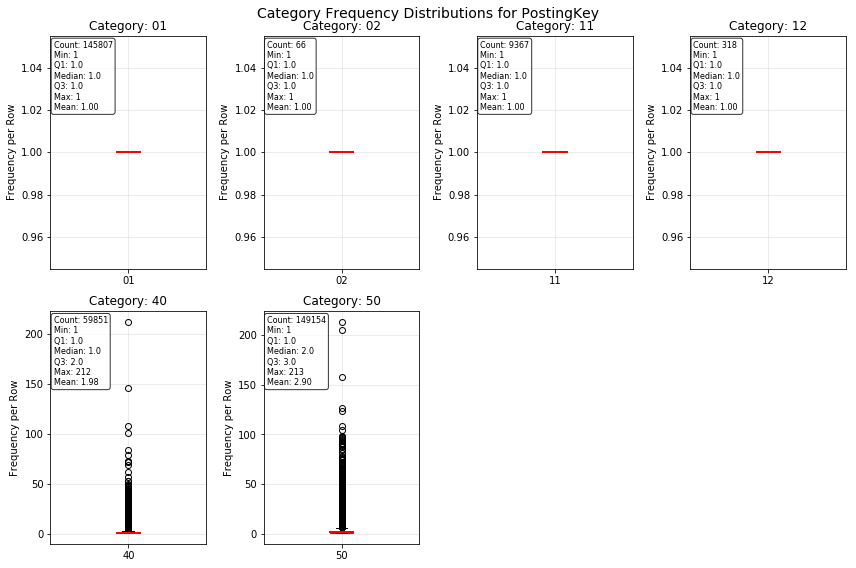

In [31]:
fig = plot_category_frequency_distributions(df_result,'PostingKey')
plt.show()

### TermsOfPayment

In [32]:
df_numeric['distinct_TermsOfPayment'].value_counts()

2    155558
1      1182
Name: distinct_TermsOfPayment, dtype: int64

2.0
2.0
🔍 Found 1182 outliers:


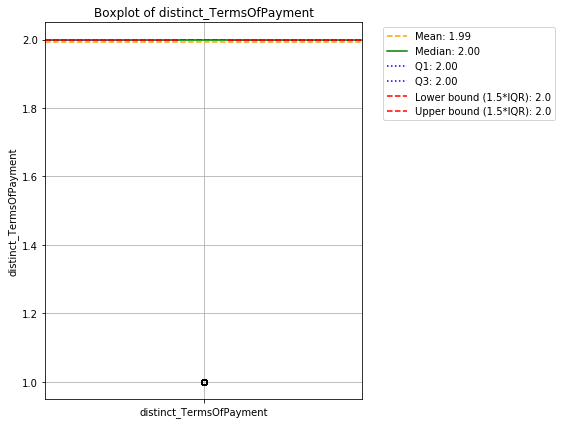

In [33]:
plot_specific_numeric_boxplot(df_numeric, 'distinct_TermsOfPayment')

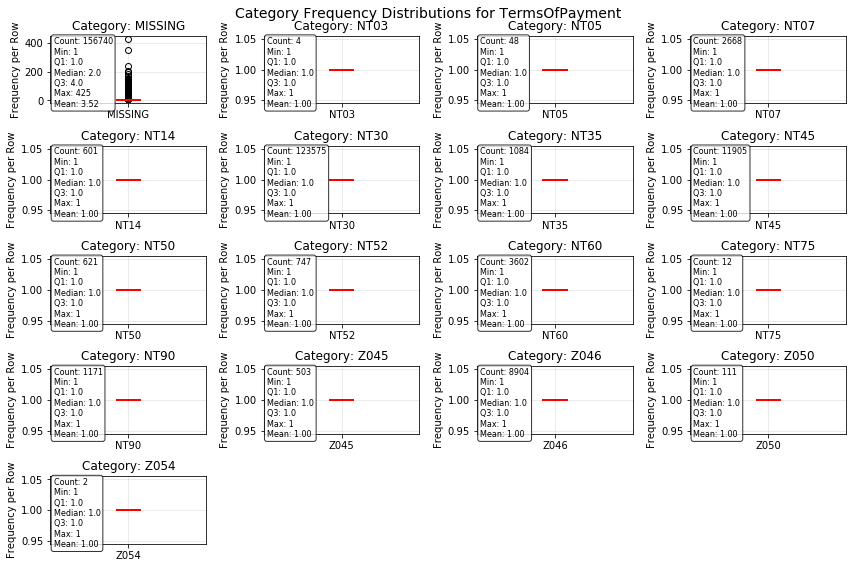

In [34]:
fig = plot_category_frequency_distributions(df_result,'TermsOfPayment')
plt.show()

### SpecialGLIndicator

In [35]:
# Finding the distribution of JEs with PaymentMethod == NULL / nan and the frequency it occurs within the JEs
value_counts = df_numeric['SpecialGLIndicator_MISSING'].value_counts()
print(value_counts)

2      61615
4      36608
3      17600
5       9193
7       8376
6       5881
8       3470
10      2853
9       2062
13      1623
11      1341
16       977
12       900
15       539
19       499
14       416
17       317
22       291
18       214
25       207
21       171
28       154
31       130
23       126
20       125
24        85
26        84
34        64
40        62
32        60
       ...  
94         2
90         2
121        2
78         2
74         2
136        1
144        1
140        1
127        1
148        1
92         1
116        1
115        1
238        1
108        1
105        1
101        1
352        1
93         1
80         1
151        1
206        1
77         1
200        1
72         1
70         1
187        1
426        1
170        1
128        1
Name: SpecialGLIndicator_MISSING, Length: 114, dtype: int64


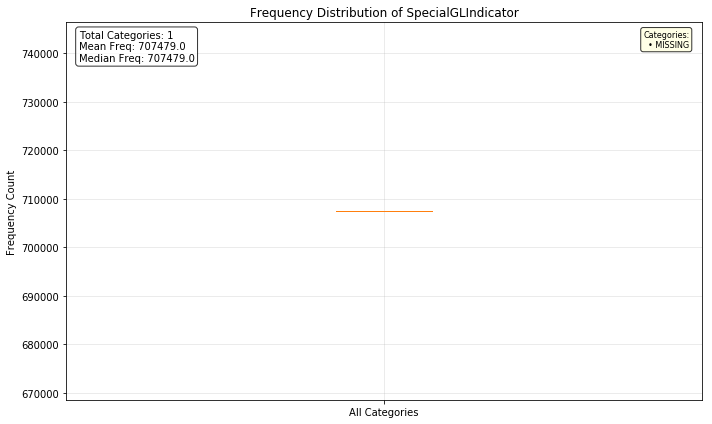

In [36]:
plot_categorical_frequency_boxplot_simple(df_result, 'SpecialGLIndicator')
plt.show()

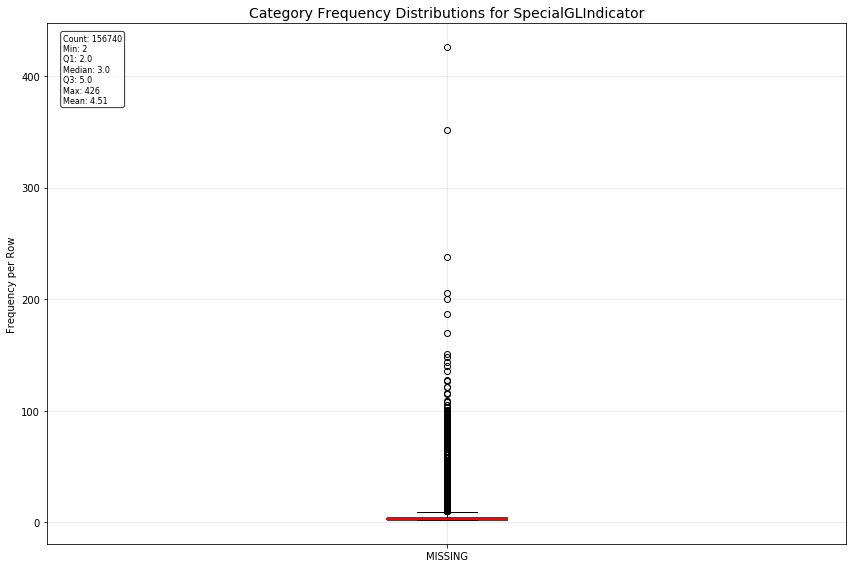

In [37]:
fig = plot_category_frequency_distributions(df_result,'SpecialGLIndicator')
plt.show()

### hasSubsequentDrCrMemo

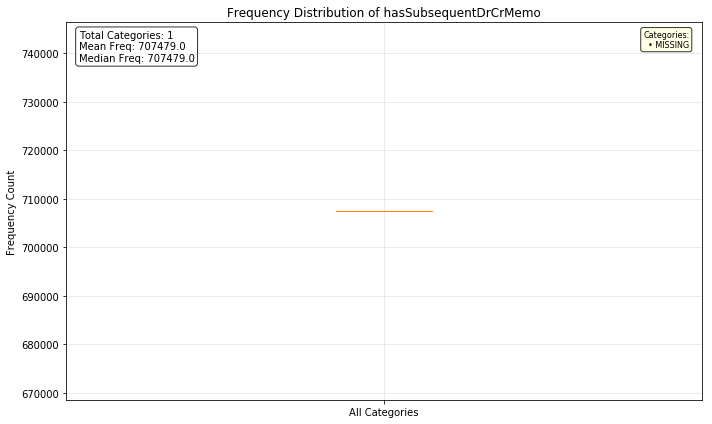

In [38]:
plot_categorical_frequency_boxplot_simple(df_result, 'hasSubsequentDrCrMemo')
plt.show()

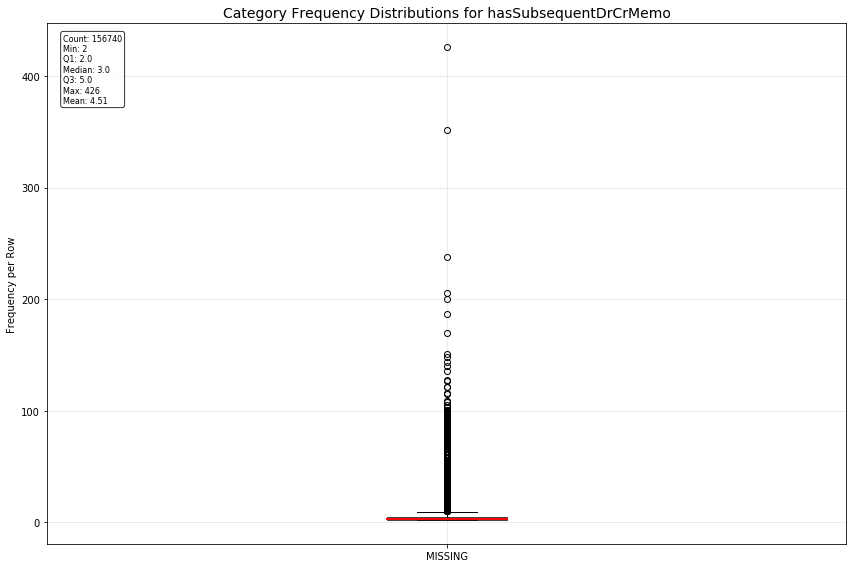

In [39]:
fig = plot_category_frequency_distributions(df_result,'hasSubsequentDrCrMemo')
plt.show()

### Payment Method

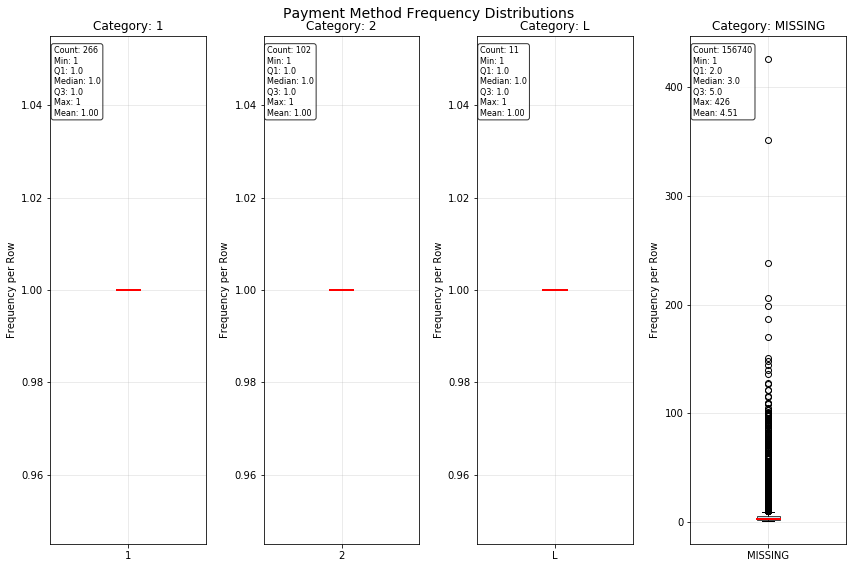

In [40]:
# Create the plot
fig = plot_category_frequency_distributions(df_result, 'PaymentMethod', 
                                              title='Payment Method Frequency Distributions')
plt.show()

In [41]:
# Finding the distribution of JEs with PaymentMethod == NULL / nan and the frequency it occurs within the JEs
value_counts = df_numeric['PaymentMethod_MISSING'].value_counts()
print(value_counts)

2      61593
4      36587
3      17617
5       9201
7       8350
6       5929
8       3439
10      2826
9       2091
13      1591
11      1339
12       933
16       929
15       568
19       495
14       435
17       315
22       248
18       218
21       214
25       195
28       153
31       131
23       126
20       126
24        96
26        84
34        63
40        62
32        59
       ...  
59         2
94         2
121        2
78         2
74         2
144        1
136        1
140        1
127        1
148        1
92         1
116        1
115        1
238        1
108        1
105        1
101        1
351        1
93         1
80         1
151        1
206        1
77         1
72         1
199        1
70         1
187        1
426        1
170        1
128        1
Name: PaymentMethod_MISSING, Length: 115, dtype: int64


In [42]:
print(value_counts.values)

[61593 36587 17617  9201  8350  5929  3439  2826  2091  1591  1339   933
   929   568   495   435   315   248   218   214   195   153   131   126
   126    96    84    63    62    59    54    46    45    41    38    38
    28    27    23    22    22    21    20    19    18    17    16    15
    13    12     9     9     9     9     7     7     7     7     6     6
     6     6     6     5     4     4     3     3     3     3     3     3
     3     3     3     3     3     3     2     2     2     2     2     2
     2     2     2     2     2     2     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1]


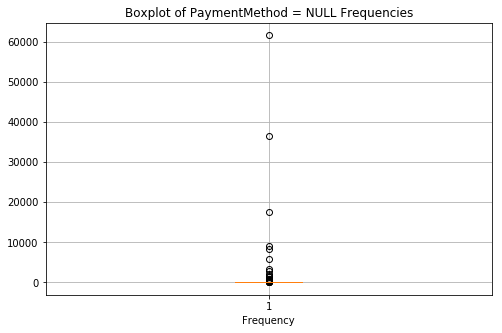

In [43]:
plt.figure(figsize=(8, 5))
plt.boxplot(value_counts.values)
plt.title('Boxplot of PaymentMethod = NULL Frequencies')
plt.xlabel('Frequency')
plt.grid(True)
plt.show()

-2.5
9.5
🔍 Found 11905 outliers:


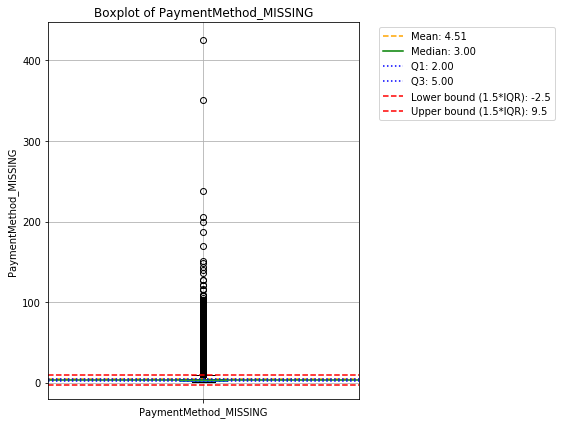

0.0
0.0
🔍 Found 102 outliers:


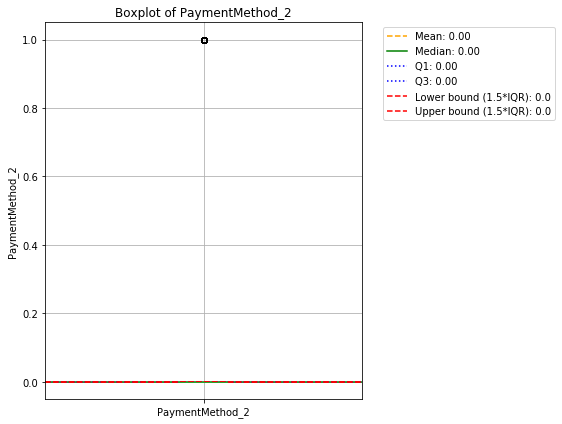

0.0
0.0
🔍 Found 266 outliers:


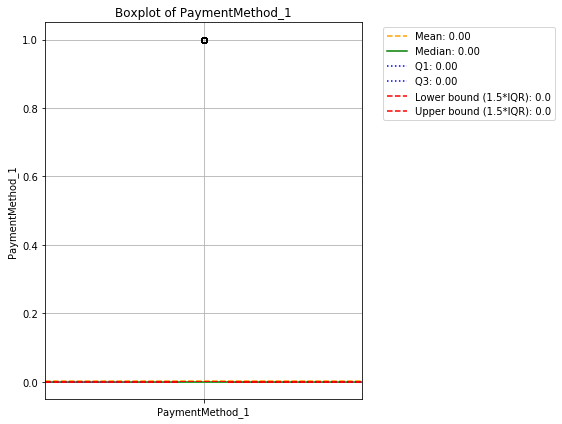

0.0
0.0
🔍 Found 11 outliers:


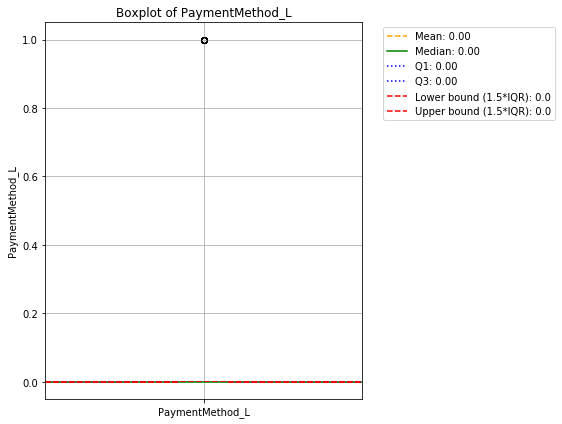

In [44]:
for col in df_numeric:
    if 'PaymentMethod' in col:
        fig = plot_specific_numeric_boxplot(df_numeric, col)
        plt.show()

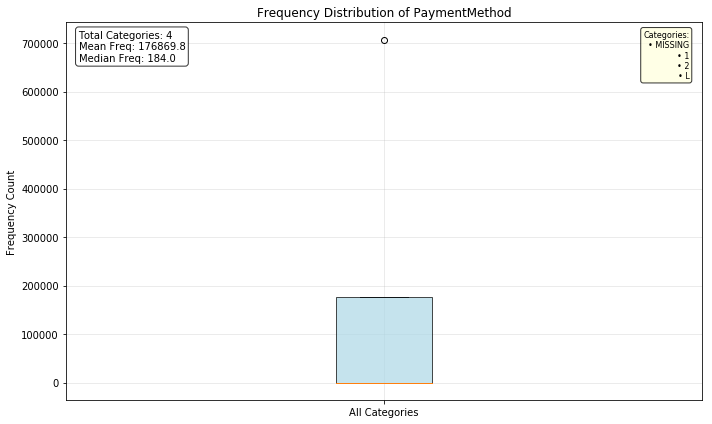

In [45]:
fig = plot_categorical_frequency_boxplot_simple(df_result, 'PaymentMethod')
plt.show()

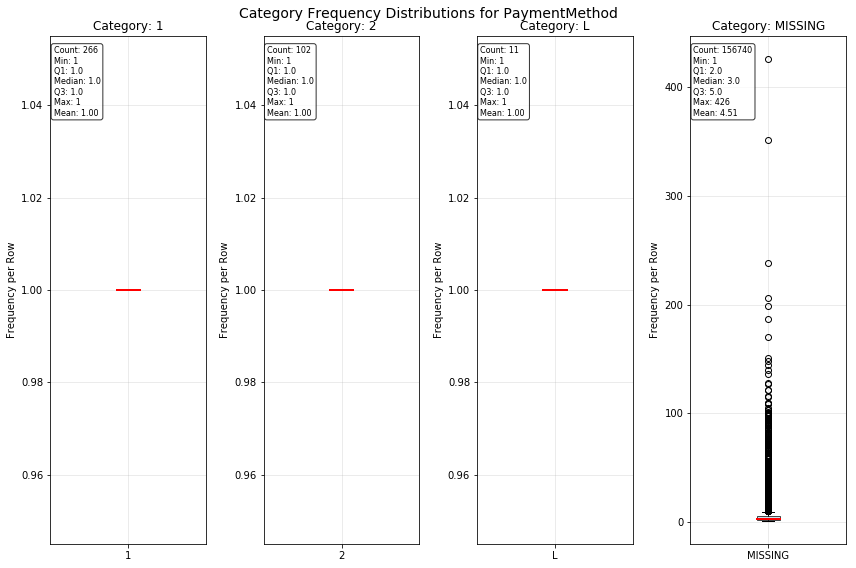

In [46]:
fig = plot_category_frequency_distributions(df_result, 'PaymentMethod')
plt.show()

### Plant

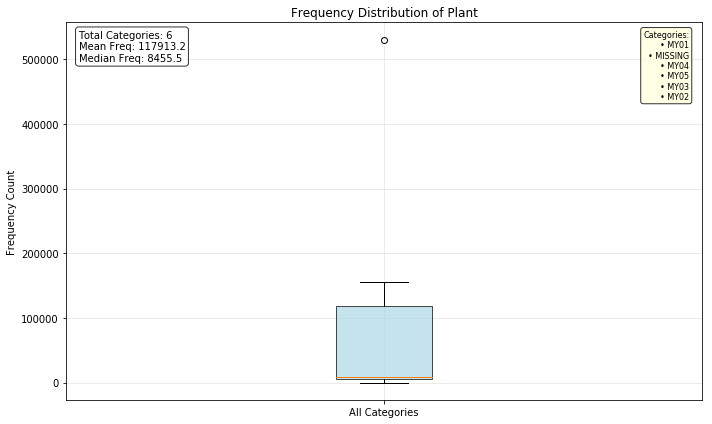

In [47]:
fig = plot_categorical_frequency_boxplot_simple(df_result, 'Plant')
plt.show()

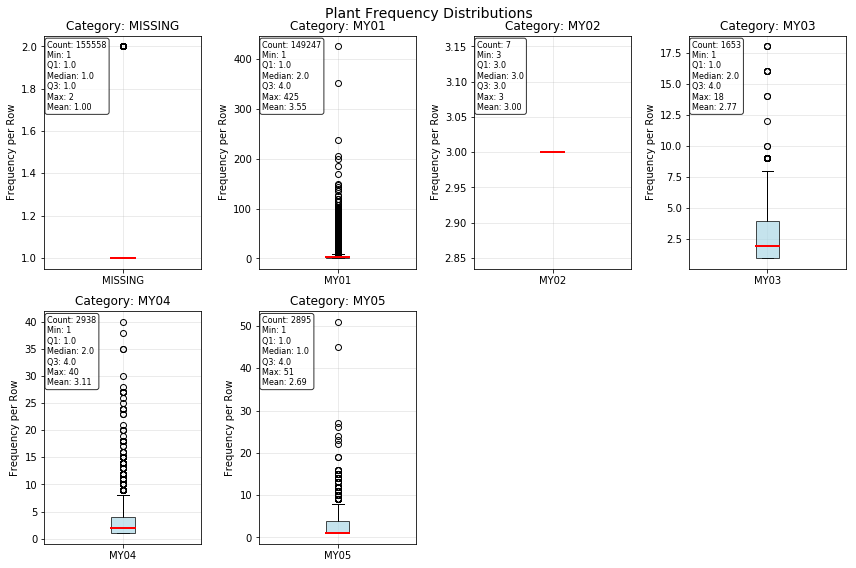

In [48]:
# Create the plot
fig = plot_category_frequency_distributions(df_result, 'Plant', 
                                              title='Plant Frequency Distributions')
plt.show()

### isLineItemAutomaticallyCreated

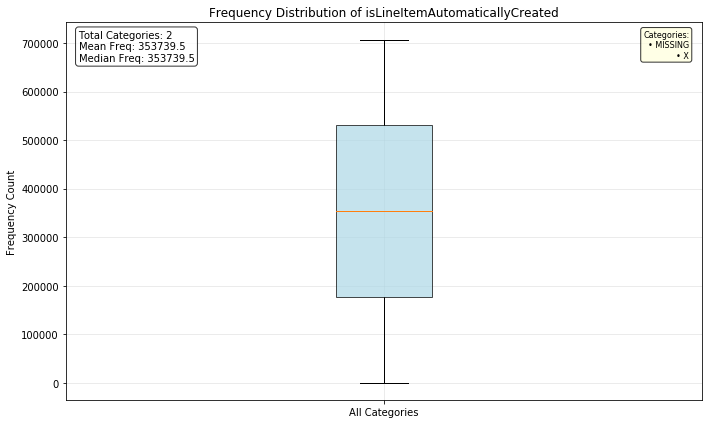

In [49]:
fig = plot_categorical_frequency_boxplot_simple(df_result, 'isLineItemAutomaticallyCreated')
plt.show()

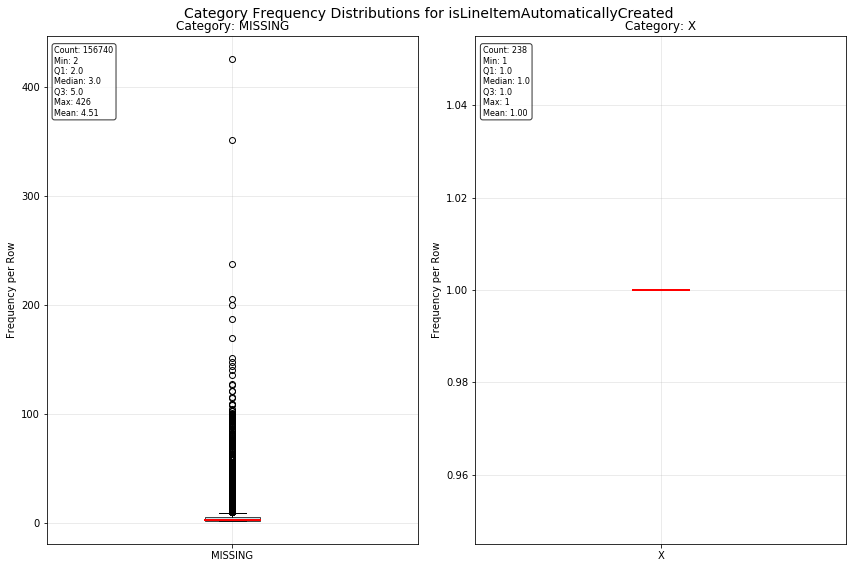

In [50]:
fig = plot_category_frequency_distributions(df_result, 'isLineItemAutomaticallyCreated')

## IND_cols

In [51]:
# For categorical features (specify target numeric column)
ind_cols = [col for col in df_numeric.columns if col.startswith('IND_')]
print(ind_cols)

['IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd', 'IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours']


In [52]:
for i in ind_cols:
    print('')
    print(df_result[i].value_counts(dropna=False))


0    145463
1     11277
Name: IND_MonthEnd, dtype: int64

0    139868
1     16872
Name: IND_QuarterEnd, dtype: int64

0    136780
1     19960
Name: IND_YearEnd, dtype: int64

0    156342
1       398
Name: IND_Weekend, dtype: int64

0    155763
1       977
Name: IND_PublicHol, dtype: int64

0    139752
1     16988
Name: IND_OutsideWorkHours, dtype: int64


## Encoded cols<br>
All cols are JE level data (so freq = 1)

In [53]:
# For categorical features (specify target numeric column)
encoded_cols = [col for col in df_numeric.columns if col.startswith('labelled_')]
categorical_cols = []
for col in encoded_cols:
    col =col.replace("labelled_","")
    categorical_cols.append(col)
print(categorical_cols)

['Document Type Description', 'TransactionCode', 'Username Type']


In [54]:
for i in categorical_cols:
    # print(result_df[i].head(5))
    print('')
    print(result_df[i].value_counts(dropna=False))


Billing Doc.Transfer    147129
Bill Doc.Tr - Cr Mem      9368
Bill Doc.Tr - Dr Mem       243
Name: Document Type Description, dtype: int64

VF01    116362
NaN      39897
VF11       471
VF04         6
VF02         2
VFX3         2
Name: TransactionCode, dtype: int64

MY        116843
System     39897
Name: Username Type, dtype: int64


### TransactionCode

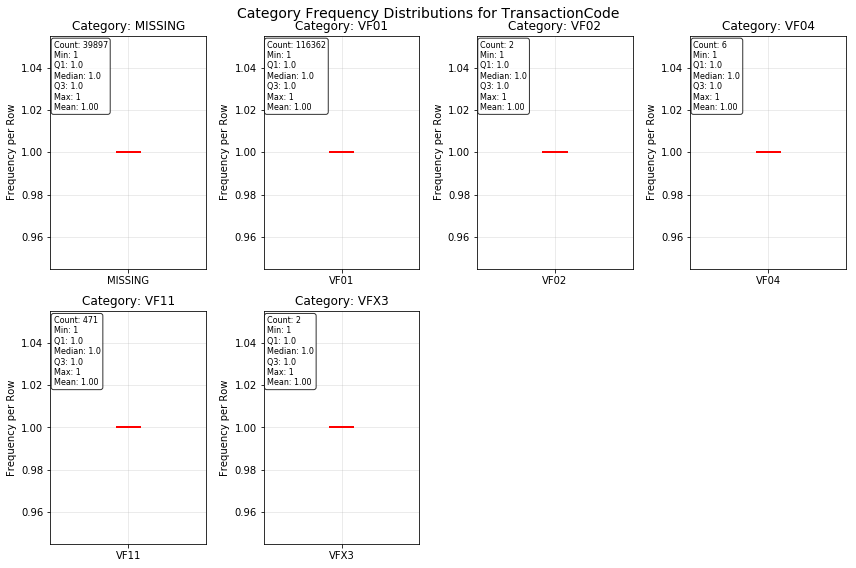

In [55]:
fig = plot_category_frequency_distributions(df_result, 'TransactionCode')
plt.show()

### Document Type Description

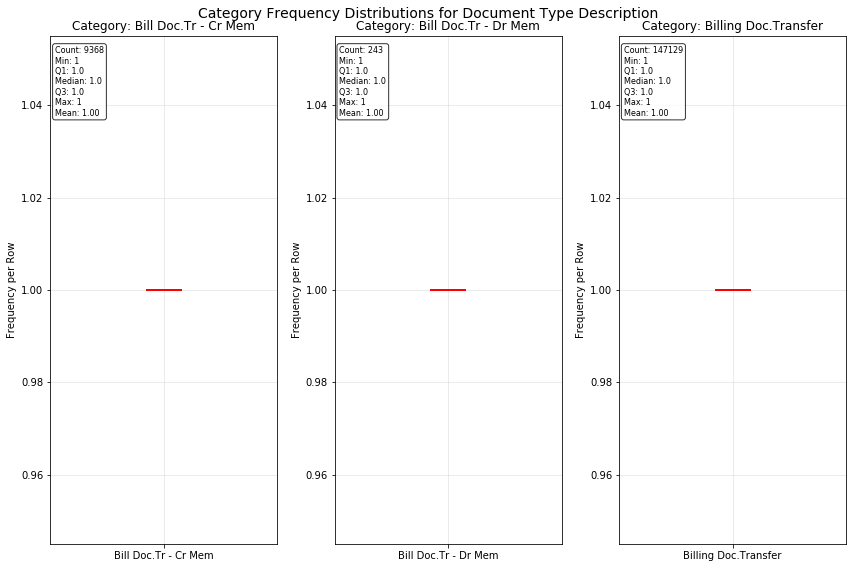

In [56]:
fig = plot_category_frequency_distributions(df_result, 'Document Type Description')
plt.show()